In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
import math
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def is_nan(x):
    return (x != x)

In [3]:
def cdr3_umi_lst_converter(x):
    z = x.replace("[","").replace("]","").replace("'","").strip()
    if z == '':
        return []
    else:
        return [int(float(zi)) for zi in z.split()]

In [4]:
def epitope_converter(x):
    #define format of datetime
    return x.replace("[","").replace("]","").replace("'","").split(" ")

In [5]:
CONVERTERS = {'umi_count_lst_mhc': literal_eval,
              'umi_count_lst_TRA': cdr3_umi_lst_converter,
              'umi_count_lst_TRB': cdr3_umi_lst_converter,
              'epitope_lst': epitope_converter,
              'cdr3_lst_TRA':epitope_converter,
              'cdr3_lst_TRB':epitope_converter}

In [6]:
def annotate_delta_umi(s):
    def calc_delta(x):
        if len(x) == 1:
            return x[-1]/0.25
        elif len(x) == 0:
            return 0
        else:
            return int((x[-1])/(x[-2]+0.25))
    return s.apply(calc_delta) #df.umi_count_lst

In [7]:
def MCC(TP, TN, FP, FN):
    return (TP * TN - FP * FN) / math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))

## Input

In [8]:
SC_RAW = '/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/exp6.2.2_TCR/processed/cellranger_out/TCR_VDJ/outs/all_contig_annotations.csv'
SC_DATA = '/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/exp6.2.2_CAT_IONTORRENT_KMA_AKB/tables/tcr_barcode.augmented.csv'
TC_DATA = '/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/exp6_MHC_IONTORRENT/barcode_library/RearrangementDetails_09-15-2020_7-57-14_AM.tsv'
BARCODE = '/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/exp6_MHC_IONTORRENT/barcode_library/barcode_specificity_annotations.xlsx'

## Load

In [9]:
raw_df = pd.read_csv(SC_RAW)
sc_df = pd.read_csv(SC_DATA, converters=CONVERTERS) #
tc_df = pd.read_csv(TC_DATA, sep='\t')
bc_df = pd.read_excel(BARCODE)

In [10]:
tc_df.drop_duplicates(subset=['amino_acid'], inplace=True) #subset=['amino_acid','v_resolved','d_resolved','j_resolved'], 
#tc_df.set_index('amino_acid', inplace=True)

In [11]:
sc_df.columns

Index(['gem', 'clonotype', 'num_clonotype', 'ct', 'length_TRA', 'cdr3_TRA',
       'umi_count_TRA', 'umi_count_lst_TRA', 'cdr3_lst_TRA', 'chain_count_TRA',
       'single_TRA', 'length_TRB', 'cdr3_TRB', 'umi_count_TRB',
       'umi_count_lst_TRB', 'cdr3_lst_TRB', 'chain_count_TRB', 'single_TRB',
       'single_chain_only', 'single_tcell', 'umi_count_tcr', 'cdr3_comb',
       'template_id_mhc', 'template_lst_mhc', 'single_barcode_mhc',
       'umi_count_mhc', 'umi_count_lst_mhc', 'read_count_mhc',
       'read_count_lst_mhc', 'template_id_cd8', 'template_lst_cd8',
       'single_barcode_cd8', 'umi_count_cd8', 'umi_count_lst_cd8',
       'read_count_cd8', 'read_count_lst_cd8', 'detected_response',
       'peptide_assayed', 'peptide', 'HLA', 'peptide_HLA', 'epitope',
       'epitope_lst', 'ADIR', 'HA-1', 'HA-2', 'KLL', 'v14', 'v15',
       'gems_per_specificity', 'gems_per_clonotype', 'binding_concordance'],
      dtype='object')

In [12]:
m_df = pd.merge(sc_df[['clonotype','umi_count_mhc','umi_count_lst_mhc','cdr3_TRA','cdr3_lst_TRA','umi_count_lst_TRA','umi_count_TRA','cdr3_TRB','cdr3_lst_TRB','umi_count_lst_TRB','umi_count_TRB',
                       'epitope','epitope_lst','peptide']], tc_df, how='left', left_on='cdr3_TRB', right_on='amino_acid')

In [13]:
#mm_df = pd.merge(m_df, raw_df[['raw_clonotype_id','cdr3', 'v_gene','d_gene','j_gene', 'is_cell']], how='left', left_on=['clonotype','cdr3_TRB'], right_on=['raw_clonotype_id','cdr3'])

In [14]:
m_df['d_umi_TRA'] = annotate_delta_umi(m_df.umi_count_lst_TRA)
m_df['d_umi_TRB'] = annotate_delta_umi(m_df.umi_count_lst_TRB)
m_df['d_umi_mhc'] = annotate_delta_umi(m_df.umi_count_lst_mhc)

## Overview

In [15]:
raw_df[['raw_clonotype_id','chain','cdr3', 'v_gene','d_gene','j_gene']].drop_duplicates() #subset=['raw_clonotype_id','cdr3']

,raw_clonotype_id,chain,cdr3,v_gene,d_gene,j_gene
0,clonotype22,TRB,CASSDAGTGYQPQHF,TRBV2,TRBD1,TRBJ1-5
1,clonotype22,TRB,None,None,None,TRBJ2-3
2,clonotype22,TRB,CQQGGEPPSYEQYF,TRBV7-3,TRBD2,TRBJ2-7
3,clonotype22,TRA,CAYRSANFGNEKLTF,TRAV38-2DV8,None,TRAJ48
4,clonotype22,TRA,None,TRAV8-6,None,TRAJ35
...,...,...,...,...,...,...
6972,None,TRA,CSSWAYNTDKLIF,TRAV6,None,TRAJ34
7140,None,TRB,CSARDRARGYGSNQPQHF,TRBV20-1,TRBD1,TRBJ1-5
7144,None,TRA,CVLLHPGPSDGTASKLTF,TRAV26-2,None,TRAJ44
7147,None,TRB,CASSLVVVDEQFF,TRBV7-3,None,TRBJ2-1


In [16]:
sc_df.sort_values(['cdr3_TRB']) #[['clonotype','cdr3_TRB','epitope','peptide']]

,gem,clonotype,num_clonotype,ct,length_TRA,cdr3_TRA,umi_count_TRA,umi_count_lst_TRA,cdr3_lst_TRA,chain_count_TRA,...,epitope_lst,ADIR,HA-1,HA-2,KLL,v14,v15,gems_per_specificity,gems_per_clonotype,binding_concordance
150,TTAGTTCCATGTAGTC-1,clonotype1,1.0,9.0,680.0,CALTGGGNKLTF,24.0,"[11, 24]","[CVVNNARLMF, CALTGGGNKLTF]",2.0,...,"[ADIR, HA-1, KLL]",NaN,NaN,NaN,5.0,NaN,NaN,10,22,0.454545
53,CGCGTTTCACAGATTC-1,clonotype1,1.0,9.0,682.0,CALTGGGNKLTF,15.0,"[6, 15]","[CVVNNARLMF, CALTGGGNKLTF]",2.0,...,[v14],NaN,NaN,NaN,NaN,1.0,NaN,2,22,0.090909
94,GGGTCTGAGAGAACAG-1,clonotype1,1.0,16.0,594.0,CVVNNARLMF,3.0,"[2, 3]","[CALTGGGNKLTF, CVVNNARLMF]",2.0,...,[v15],NaN,NaN,NaN,NaN,NaN,1.0,1,22,0.045455
193,GACGTTATCTAAGCCA-1,None,0.0,1.0,NaN,NaN,NaN,[],[],NaN,...,[v15],NaN,NaN,NaN,NaN,NaN,1.0,7,89,0.078652
56,CGGACTGAGTTGAGTA-1,clonotype1,1.0,9.0,681.0,CALTGGGNKLTF,14.0,"[11, 14]","[CVVNNARLMF, CALTGGGNKLTF]",2.0,...,"[ADIR, KLL]",NaN,NaN,NaN,3.0,NaN,NaN,10,22,0.454545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,TACGGTACATGTTGAC-1,None,0.0,12.0,591.0,CAETAGYGGSQGNLIF,1.0,[1],[CAETAGYGGSQGNLIF],1.0,...,[v14],NaN,NaN,NaN,NaN,1.0,NaN,8,89,0.089888
122,TCACGAATCCAACCAA-1,None,0.0,100.0,396.0,CALYSGGGADGLTF,1.0,[1],[CALYSGGGADGLTF],1.0,...,"[v15, HA-2, v14, KLL]",NaN,NaN,NaN,8.0,NaN,NaN,16,89,0.179775
128,TCGTAGAAGCTAGTGG-1,None,0.0,11.0,557.0,CSNSGSRLTF,1.0,"[1, 1]","[CAASNLVF, CSNSGSRLTF]",2.0,...,"[KLL, v15, v14, HA-1, ADIR]",18.0,NaN,NaN,NaN,NaN,NaN,21,89,0.235955
152,TTGGAACTCTAAGCCA-1,None,0.0,5.0,486.0,CAASNLVF,1.0,[1],[CAASNLVF],1.0,...,"[v15, KLL]",NaN,NaN,NaN,1.0,NaN,NaN,16,89,0.179775


In [17]:
tc_df

,sample_name,productive_frequency,templates,amino_acid,rearrangement,v_resolved,d_resolved,j_resolved
0,KLL_TCRB,0.998989,52353,CAIRKQDQNTGELFF,GAGTCCGCTACCAGCTCCCAGACATCTGTGTACTTCTGTGCCATCA...,TCRBV10-03*01,TCRBD01-01*01,TCRBJ02-02*01
1,HA-1-1_TCRB,0.995748,52697,CASSLVVVDEQFF,GAGATCCAGCGCACAGAGCAGGGGGACTCGGCCATGTATCTCTGTG...,TCRBV07-09*01,unknown,TCRBJ02-01*01
2,HA-2-1_TCRB,0.991994,28622,CASSRTSGANNEQFF,CAGCAGGTAGTGCGAGGAGATTCGGCAGCTTATTTCTGTGCCAGCT...,TCRBV18-01*01,TCRBD02-01*01,TCRBJ02-01*01
3,ADIR_TCRB,0.974163,62098,CASSQGTAEKLFF,CACCTACACGCCCTGCAGCCAGAAGACTCAGCCCTGTATCTCTGCG...,TCRBV04-01*01,unknown,TCRBJ01-04*01
4,ADIR_TCRB,0.002573,164,CASSFSTGELFF,CTGATCCTGGAGTCGCCCAGCCCCAACCAGACCTCTCTGTACTTCT...,TCRBV27-01*01,TCRBD02-01,TCRBJ02-02*01
...,...,...,...,...,...,...,...,...
1063,ADIR_TCRB,0.000016,1,CAWSFPGGEFGSPLHF,AAGCTCCTTCTCAGTGACTCTGGCTTCTATCTCTGTGCCTGGAGTT...,TCRBV30-01*01,TCRBD02-01*01,TCRBJ01-06*02
1064,ADIR_TCRB,0.000016,1,CASSLWENSPLHF,AAGATCCAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTG...,TCRBV12-03/12-04*01,TCRBD02-01*02,TCRBJ01-06*02
1065,ADIR_TCRB,0.000016,1,CASSLLTSGSGDTGELFF,GAGCTGGGGGACTCGGCCCTTTATCTTTGCGCCAGCAGCTTGTTAA...,TCRBV05-01*01,TCRBD02-01*02,TCRBJ02-02*01
1066,ADIR_TCRB,0.000016,1,CSARGGSLYEQFF,ACTGTGAGCAACATGAGCCCTGAAGACAGCAGCATATATCTCTGCA...,TCRBV29-01*03,TCRBD02-01*01,TCRBJ02-01*01


In [18]:
sc_df[sc_df.cdr3_TRA == 'CSNSGSRLTF'][['clonotype', 'cdr3_TRA', 'cdr3_TRB','peptide','epitope_lst','epitope',
                                                                'umi_count_lst_TRA','umi_count_lst_TRB','umi_count_lst_mhc']]

,clonotype,cdr3_TRA,cdr3_TRB,peptide,epitope_lst,epitope,umi_count_lst_TRA,umi_count_lst_TRB,umi_count_lst_mhc
2,clonotype5,CSNSGSRLTF,CASSQGTAEKLFF,SVAPALALFPA,"[KLL, ADIR]",ADIR,[11],"[3, 27]","[1, 3]"
12,clonotype5,CSNSGSRLTF,CASSQGTAEKLFF,SVAPALALFPA,"[v14, ADIR]",ADIR,[5],[26],"[1, 4]"
33,clonotype5,CSNSGSRLTF,CASSQGTAEKLFF,KLLEIAPNC,"[ADIR, KLL]",KLL,[12],[4],"[1, 1]"
39,clonotype5,CSNSGSRLTF,CASSQGTAEKLFF,SVAPALALFPA,[ADIR],ADIR,[2],[15],[3]
63,clonotype5,CSNSGSRLTF,CASSQGTAEKLFF,SVAPALALFPA,"[HA-2, v14, KLL, HA-1, ADIR]",ADIR,[13],[27],"[1, 2, 2, 4, 20]"
66,clonotype5,CSNSGSRLTF,CASSQGTAEKLFF,SVAPALALFPA,[ADIR],ADIR,[3],[34],[4]
68,clonotype12,CSNSGSRLTF,CASSQGTAEKLFF,KLLEIAPNC,"[v14, ADIR, HA-2, HA-1, KLL]",KLL,"[3, 4, 4]","[1, 15, 26]","[1, 1, 1, 7, 11]"
72,clonotype5,CSNSGSRLTF,CASSQGTAEKLFF,SVAPALALFPA,"[ADIR, KLL, HA-2, HA-1]",ADIR,[3],[24],"[1, 1, 1, 1]"
79,clonotype12,CSNSGSRLTF,CASSQGTAEKLFF,SVAPALALFPA,"[v14, v15, HA-1, ADIR]",ADIR,"[2, 3, 4]","[6, 25]","[1, 1, 3, 16]"
80,clonotype5,CSNSGSRLTF,CASSQGTAEKLFF,SVAPALALFPA,"[v14, v15, KLL, HA-2, HA-1, ADIR]",ADIR,[2],[17],"[1, 1, 2, 3, 5, 36]"


# Looking at top 4 CDR3s

## KLL 0.999 frequency

In [19]:
m_df.loc[m_df.cdr3_TRB == 'CAIRKQDQNTGELFF', ['cdr3_TRA', 'cdr3_TRB','peptide','epitope_lst', 'epitope','sample_name',
                                                'umi_count_lst_TRA','umi_count_lst_TRB','umi_count_lst_mhc']].sort_values(['sample_name','epitope'])#.drop_duplicates()

,cdr3_TRA,cdr3_TRB,peptide,epitope_lst,epitope,sample_name,umi_count_lst_TRA,umi_count_lst_TRB,umi_count_lst_mhc
47,CALTGGGNKLTF,CAIRKQDQNTGELFF,SVAPALALFPA,[ADIR],ADIR,KLL_TCRB,"[2, 6]",[20],[1]
50,CALTGGGNKLTF,CAIRKQDQNTGELFF,SVAPALALFPA,[ADIR],ADIR,KLL_TCRB,"[4, 12]",[19],[1]
57,CALTGGGNKLTF,CAIRKQDQNTGELFF,SVAPALALFPA,[ADIR],ADIR,KLL_TCRB,"[1, 5]",[4],[1]
59,CALTGGGNKLTF,CAIRKQDQNTGELFF,SVAPALALFPA,[ADIR],ADIR,KLL_TCRB,"[6, 7]",[24],[1]
69,CALTGGGNKLTF,CAIRKQDQNTGELFF,SVAPALALFPA,[ADIR],ADIR,KLL_TCRB,"[12, 14]",[76],[1]
85,CVVNNARLMF,CAIRKQDQNTGELFF,SVAPALALFPA,"[v14, v15, KLL, ADIR]",ADIR,KLL_TCRB,"[5, 7]",[13],"[1, 1, 3, 12]"
115,CVVNNARLMF,CAIRKQDQNTGELFF,SVAPALALFPA,[ADIR],ADIR,KLL_TCRB,"[5, 5]",[44],[1]
127,CVVNNARLMF,CAIRKQDQNTGELFF,SVAPALALFPA,[ADIR],ADIR,KLL_TCRB,"[2, 4, 6]","[6, 9]",[2]
148,CALTGGGNKLTF,CAIRKQDQNTGELFF,SVAPALALFPA,"[KLL, ADIR]",ADIR,KLL_TCRB,"[11, 15]","[1, 32]","[2, 4]"
184,NaN,CAIRKQDQNTGELFF,SVAPALALFPA,"[HA-2, v15, v14, KLL, HA-1, ADIR]",ADIR,KLL_TCRB,[],[1],"[1, 1, 1, 2, 2, 10]"


## HA-1 0.996

In [20]:
m_df.loc[m_df.cdr3_TRB == 'CASSLVVVDEQFF', ['cdr3_TRA', 'cdr3_TRB','peptide','epitope_lst', 'epitope','sample_name',
                                                'umi_count_lst_TRA','umi_count_lst_TRB','umi_count_lst_mhc']].sort_values(['sample_name','epitope'])#.drop_duplicates()

,cdr3_TRA,cdr3_TRB,peptide,epitope_lst,epitope,sample_name,umi_count_lst_TRA,umi_count_lst_TRB,umi_count_lst_mhc
149,CAASNLVF,CASSLVVVDEQFF,SVAPALALFPA,[ADIR],ADIR,HA-1-1_TCRB,[6],[41],[1]
178,NaN,CASSLVVVDEQFF,SVAPALALFPA,[ADIR],ADIR,HA-1-1_TCRB,[],[1],[1]
196,NaN,CASSLVVVDEQFF,SVAPALALFPA,[ADIR],ADIR,HA-1-1_TCRB,[],[1],[1]
203,NaN,CASSLVVVDEQFF,SVAPALALFPA,"[HA-2, HA-1, ADIR]",ADIR,HA-1-1_TCRB,[],[1],"[1, 2, 11]"
204,NaN,CASSLVVVDEQFF,SVAPALALFPA,[ADIR],ADIR,HA-1-1_TCRB,[],[1],[1]
216,NaN,CASSLVVVDEQFF,SVAPALALFPA,[ADIR],ADIR,HA-1-1_TCRB,[],[1],[1]
223,NaN,CASSLVVVDEQFF,SVAPALALFPA,[ADIR],ADIR,HA-1-1_TCRB,[],[2],[1]
16,CAASNLVF,CASSLVVVDEQFF,VLHDDLLEA,"[KLL, v14, ADIR, HA-1]",HA-1,HA-1-1_TCRB,[7],[20],"[1, 1, 2, 6]"
17,CAASNLVF,CASSLVVVDEQFF,VLHDDLLEA,"[ADIR, HA-1]",HA-1,HA-1-1_TCRB,[4],[7],"[1, 2]"
26,CAASNLVF,CASSLVVVDEQFF,VLHDDLLEA,[HA-1],HA-1,HA-1-1_TCRB,[3],[6],[1]


## HA-2 0.992

In [21]:
m_df.loc[m_df.cdr3_TRB == 'CASSRTSGANNEQFF', ['cdr3_TRA', 'cdr3_TRB','peptide','epitope_lst', 'epitope','sample_name',
                                                'umi_count_lst_TRA','umi_count_lst_TRB','umi_count_lst_mhc']].sort_values(['sample_name','epitope'])#.drop_duplicates()

,cdr3_TRA,cdr3_TRB,peptide,epitope_lst,epitope,sample_name,umi_count_lst_TRA,umi_count_lst_TRB,umi_count_lst_mhc
157,NaN,CASSRTSGANNEQFF,SVAPALALFPA,[ADIR],ADIR,HA-2-1_TCRB,[],[1],[3]
161,NaN,CASSRTSGANNEQFF,VLHDDLLEA,[HA-1],HA-1,HA-2-1_TCRB,[],[1],[1]
202,NaN,CASSRTSGANNEQFF,VLHDDLLEA,[HA-1],HA-1,HA-2-1_TCRB,[],[1],[1]
70,CAETAGYGGSQGNLIF,CASSRTSGANNEQFF,YIGEVLVSV,"[HA-1, HA-2]",HA-2,HA-2-1_TCRB,[5],[4],"[1, 8]"
125,CAETAGYGGSQGNLIF,CASSRTSGANNEQFF,YIGEVLVSV,"[v14, HA-1, ADIR, KLL, HA-2]",HA-2,HA-2-1_TCRB,[13],[23],"[1, 1, 2, 2, 11]"
171,NaN,CASSRTSGANNEQFF,YIGEVLVSV,"[HA-1, KLL, HA-2]",HA-2,HA-2-1_TCRB,[],[1],"[1, 1, 6]"
173,NaN,CASSRTSGANNEQFF,KLLEIAPNC,[KLL],KLL,HA-2-1_TCRB,[],[1],[1]


## ADIR 0.974

In [22]:
m_df.loc[m_df.cdr3_TRB == 'CASSQGTAEKLFF', ['cdr3_TRA', 'cdr3_TRB','peptide','epitope_lst', 'epitope','sample_name',
                                                'umi_count_lst_TRA','umi_count_lst_TRB','umi_count_lst_mhc']].sort_values(['sample_name','epitope'])#.drop_duplicates()

,cdr3_TRA,cdr3_TRB,peptide,epitope_lst,epitope,sample_name,umi_count_lst_TRA,umi_count_lst_TRB,umi_count_lst_mhc
2,CSNSGSRLTF,CASSQGTAEKLFF,SVAPALALFPA,"[KLL, ADIR]",ADIR,ADIR_TCRB,[11],"[3, 27]","[1, 3]"
12,CSNSGSRLTF,CASSQGTAEKLFF,SVAPALALFPA,"[v14, ADIR]",ADIR,ADIR_TCRB,[5],[26],"[1, 4]"
39,CSNSGSRLTF,CASSQGTAEKLFF,SVAPALALFPA,[ADIR],ADIR,ADIR_TCRB,[2],[15],[3]
63,CSNSGSRLTF,CASSQGTAEKLFF,SVAPALALFPA,"[HA-2, v14, KLL, HA-1, ADIR]",ADIR,ADIR_TCRB,[13],[27],"[1, 2, 2, 4, 20]"
66,CSNSGSRLTF,CASSQGTAEKLFF,SVAPALALFPA,[ADIR],ADIR,ADIR_TCRB,[3],[34],[4]
72,CSNSGSRLTF,CASSQGTAEKLFF,SVAPALALFPA,"[ADIR, KLL, HA-2, HA-1]",ADIR,ADIR_TCRB,[3],[24],"[1, 1, 1, 1]"
76,CAASNLVF,CASSQGTAEKLFF,SVAPALALFPA,[ADIR],ADIR,ADIR_TCRB,[1],[8],[3]
79,CSNSGSRLTF,CASSQGTAEKLFF,SVAPALALFPA,"[v14, v15, HA-1, ADIR]",ADIR,ADIR_TCRB,"[2, 3, 4]","[6, 25]","[1, 1, 3, 16]"
80,CSNSGSRLTF,CASSQGTAEKLFF,SVAPALALFPA,"[v14, v15, KLL, HA-2, HA-1, ADIR]",ADIR,ADIR_TCRB,[2],[17],"[1, 1, 2, 3, 5, 36]"
104,CSNSGSRLTF,CASSQGTAEKLFF,SVAPALALFPA,"[HA-1, ADIR]",ADIR,ADIR_TCRB,[3],[27],"[1, 2]"


In [23]:
m_df['KLL_cdr3'] = sc_df.cdr3_lst_TRB.apply(lambda x: 'CAIRKQDQNTGELFF' in x)
m_df['HA-1_cdr3'] = sc_df.cdr3_lst_TRB.apply(lambda x: 'CASSLVVVDEQFF' in x)
m_df['HA-2_cdr3'] = sc_df.cdr3_lst_TRB.apply(lambda x: 'CASSRTSGANNEQFF' in x)
m_df['ADIR_cdr3'] = sc_df.cdr3_lst_TRB.apply(lambda x: 'CASSQGTAEKLFF' in x)

In [24]:
m_df.columns

Index(['clonotype', 'umi_count_mhc', 'umi_count_lst_mhc', 'cdr3_TRA',
       'cdr3_lst_TRA', 'umi_count_lst_TRA', 'umi_count_TRA', 'cdr3_TRB',
       'cdr3_lst_TRB', 'umi_count_lst_TRB', 'umi_count_TRB', 'epitope',
       'epitope_lst', 'peptide', 'sample_name', 'productive_frequency',
       'templates', 'amino_acid', 'rearrangement', 'v_resolved', 'd_resolved',
       'j_resolved', 'd_umi_TRA', 'd_umi_TRB', 'd_umi_mhc', 'KLL_cdr3',
       'HA-1_cdr3', 'HA-2_cdr3', 'ADIR_cdr3'],
      dtype='object')

In [25]:
m_df.sort_values(by='productive_frequency')[['cdr3_lst_TRA', 'cdr3_lst_TRB','peptide','epitope_lst', 'epitope','sample_name',
                                             'umi_count_lst_TRA','umi_count_lst_TRB','umi_count_lst_mhc',
                                             'KLL_cdr3','HA-1_cdr3','HA-2_cdr3','ADIR_cdr3']].head(60)

,cdr3_lst_TRA,cdr3_lst_TRB,peptide,epitope_lst,epitope,sample_name,umi_count_lst_TRA,umi_count_lst_TRB,umi_count_lst_mhc,KLL_cdr3,HA-1_cdr3,HA-2_cdr3,ADIR_cdr3
2,[CSNSGSRLTF],"[CASSLVVVDEQFF, CASSQGTAEKLFF]",SVAPALALFPA,"[KLL, ADIR]",ADIR,ADIR_TCRB,[11],"[3, 27]","[1, 3]",False,True,False,True
68,"[CVVNNARLMF, CALTGGGNKLTF, CSNSGSRLTF]","[CASSLVVVDEQFF, CAIRKQDQNTGELFF, CASSQGTAEKLFF]",KLLEIAPNC,"[v14, ADIR, HA-2, HA-1, KLL]",KLL,ADIR_TCRB,"[3, 4, 4]","[1, 15, 26]","[1, 1, 1, 7, 11]",True,True,False,True
72,[CSNSGSRLTF],[CASSQGTAEKLFF],SVAPALALFPA,"[ADIR, KLL, HA-2, HA-1]",ADIR,ADIR_TCRB,[3],[24],"[1, 1, 1, 1]",False,False,False,True
76,[CAASNLVF],[CASSQGTAEKLFF],SVAPALALFPA,[ADIR],ADIR,ADIR_TCRB,[1],[8],[3],False,False,False,True
79,"[CVVNNARLMF, CALTGGGNKLTF, CSNSGSRLTF]","[CAIRKQDQNTGELFF, CASSQGTAEKLFF]",SVAPALALFPA,"[v14, v15, HA-1, ADIR]",ADIR,ADIR_TCRB,"[2, 3, 4]","[6, 25]","[1, 1, 3, 16]",True,False,False,True
80,[CSNSGSRLTF],[CASSQGTAEKLFF],SVAPALALFPA,"[v14, v15, KLL, HA-2, HA-1, ADIR]",ADIR,ADIR_TCRB,[2],[17],"[1, 1, 2, 3, 5, 36]",False,False,False,True
179,[],[CASSQGTAEKLFF],VTEHDTLLY,[v15],v15,ADIR_TCRB,[],[1],[1],False,False,False,True
66,[CSNSGSRLTF],[CASSQGTAEKLFF],SVAPALALFPA,[ADIR],ADIR,ADIR_TCRB,[3],[34],[4],False,False,False,True
172,[],[CASSQGTAEKLFF],VLHDDLLEA,[HA-1],HA-1,ADIR_TCRB,[],[1],[1],False,False,False,True
104,[CSNSGSRLTF],[CASSQGTAEKLFF],SVAPALALFPA,"[HA-1, ADIR]",ADIR,ADIR_TCRB,[3],[27],"[1, 2]",False,False,False,True


# TP, FP, TN, FN

Positives: CDR3 sequences that match abundant clones.

Negatives: CDR3 sequences that do not match abundant clones.

TP: CDR3 match + epitope match

FP: CDR3 match - epitope match

TN: no CDR3 match and no epitope match (viral)

FN: no CDR3 match but clonal epitope

In [26]:
sc_df.columns

Index(['gem', 'clonotype', 'num_clonotype', 'ct', 'length_TRA', 'cdr3_TRA',
       'umi_count_TRA', 'umi_count_lst_TRA', 'cdr3_lst_TRA', 'chain_count_TRA',
       'single_TRA', 'length_TRB', 'cdr3_TRB', 'umi_count_TRB',
       'umi_count_lst_TRB', 'cdr3_lst_TRB', 'chain_count_TRB', 'single_TRB',
       'single_chain_only', 'single_tcell', 'umi_count_tcr', 'cdr3_comb',
       'template_id_mhc', 'template_lst_mhc', 'single_barcode_mhc',
       'umi_count_mhc', 'umi_count_lst_mhc', 'read_count_mhc',
       'read_count_lst_mhc', 'template_id_cd8', 'template_lst_cd8',
       'single_barcode_cd8', 'umi_count_cd8', 'umi_count_lst_cd8',
       'read_count_cd8', 'read_count_lst_cd8', 'detected_response',
       'peptide_assayed', 'peptide', 'HLA', 'peptide_HLA', 'epitope',
       'epitope_lst', 'ADIR', 'HA-1', 'HA-2', 'KLL', 'v14', 'v15',
       'gems_per_specificity', 'gems_per_clonotype', 'binding_concordance'],
      dtype='object')

In [27]:
m_df.columns

Index(['clonotype', 'umi_count_mhc', 'umi_count_lst_mhc', 'cdr3_TRA',
       'cdr3_lst_TRA', 'umi_count_lst_TRA', 'umi_count_TRA', 'cdr3_TRB',
       'cdr3_lst_TRB', 'umi_count_lst_TRB', 'umi_count_TRB', 'epitope',
       'epitope_lst', 'peptide', 'sample_name', 'productive_frequency',
       'templates', 'amino_acid', 'rearrangement', 'v_resolved', 'd_resolved',
       'j_resolved', 'd_umi_TRA', 'd_umi_TRB', 'd_umi_mhc', 'KLL_cdr3',
       'HA-1_cdr3', 'HA-2_cdr3', 'ADIR_cdr3'],
      dtype='object')

In [15]:
TP = m_df.apply(lambda row:
                False if is_nan(row.sample_name) else
                (True if row.epitope in row.sample_name else False), axis=1)
FP = m_df.apply(lambda row:
                False if is_nan(row.sample_name) else
                (False if row.epitope in row.sample_name else True), axis=1)
ne = m_df.sample_name.isna()
cl = m_df.epitope.isin(['ADIR','KLL','HA-1','HA-2'])

In [16]:
print('TP', m_df[TP].shape[0])
print('FP', m_df[FP].shape[0])
print('FN', m_df[ne & cl].shape[0])
print('TN', m_df[ne & ~cl].shape[0])

TP 65
FP 61
FN 39
TN 61


In [17]:
mcc_df = pd.DataFrame(columns=['da','db','dm','ua','ub','um','n','TP','TN','FP','FN','MCC'])

In [18]:
i = 0
for da in [1, 1.2, 1.4, 1.6, 1.8]:
    for db in [1, 1.2, 1.4, 1.6, 1.8]:
        for dm in [1, 1.2, 1.4, 1.6, 1.8]:
            for ua in range(4):
                for ub in range(4):
                    for um in range(4):
                        filtering = m_df.apply(lambda row: True if ((row.d_umi_TRA > da) &
                                                                    (row.d_umi_TRB > db) &
                                                                    (row.d_umi_mhc > dm) &
                                                                    (row.umi_count_TRA > ua) &
                                                                    (row.umi_count_TRB > ub) &
                                                                    (row.umi_count_mhc > um)) else False, axis=1)
                        
                        mcc_df.loc[i, 'da'] = da + 1
                        mcc_df.loc[i, 'db'] = db + 1
                        mcc_df.loc[i, 'dm'] = dm + 1
                        mcc_df.loc[i, 'ua'] = ua + 1
                        mcc_df.loc[i, 'ub'] = ub + 1
                        mcc_df.loc[i, 'um'] = um + 1
                        mcc_df.loc[i, 'n'] = filtering.sum()
                        mcc_df.loc[i, 'TP'] = m_df[filtering & TP].shape[0]
                        mcc_df.loc[i, 'FP'] = m_df[filtering & FP].shape[0]
                        mcc_df.loc[i, 'TN'] = m_df[filtering & ne & ~cl].shape[0]
                        mcc_df.loc[i, 'FN'] = m_df[filtering & ne & cl].shape[0]
                        
                        i += 1

In [19]:
mcc_df['MCC'] = mcc_df.apply(lambda row: MCC(row.TP, row.TN, row.FP, row.FN), axis=1)

In [20]:
mcc_df.sort_values(by=['MCC','n'], ascending=[False, False])

,da,db,dm,ua,ub,um,n,TP,TN,FP,FN,MCC
1,2,2,2,1,1,2,64,31,33,0,0,1.000000
65,2,2,2.2,1,1,2,64,31,33,0,0,1.000000
129,2,2,2.4,1,1,2,64,31,33,0,0,1.000000
193,2,2,2.6,1,1,2,64,31,33,0,0,1.000000
257,2,2,2.8,1,1,2,64,31,33,0,0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
7732,2.8,2.8,2,4,2,1,53,22,18,7,6,0.507165
7796,2.8,2.8,2.2,4,2,1,53,22,18,7,6,0.507165
7860,2.8,2.8,2.4,4,2,1,53,22,18,7,6,0.507165
7924,2.8,2.8,2.6,4,2,1,53,22,18,7,6,0.507165


In [21]:
mcc_df.sort_values(by=['MCC','n'], ascending=[False, False]).to_csv('mcc.csv', index=False)

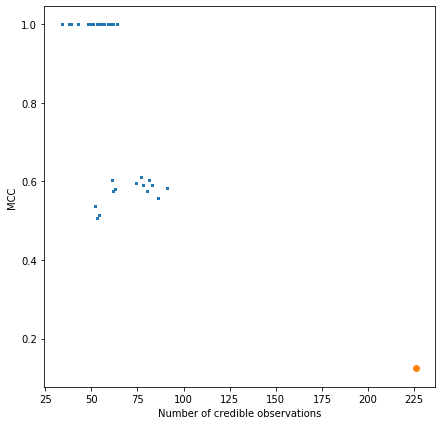

In [22]:
plt.figure(figsize=(7,7))
plt.scatter(mcc_df.n, mcc_df.MCC, s=1)
plt.scatter(m_df.shape[0], MCC(65, 61, 61, 39))
plt.xlabel('Number of credible observations')
plt.ylabel('MCC')
plt.show()

In [142]:
i = 0
mcc_df.loc[i, 'description'] = 'all observations'
mcc_df.loc[i, 'n'] = m_df.shape[0]
mcc_df.loc[i, 'TP'] = m_df[TP].shape[0]
mcc_df.loc[i, 'FP'] = m_df[FP].shape[0]
mcc_df.loc[i, 'TN'] = m_df[ne & ~cl].shape[0]
mcc_df.loc[i, 'FN'] = m_df[ne & cl].shape[0]

In [143]:
i = 1
filtering = m_df.umi_count_lst_TRA.apply(lambda x: x != [])

mcc_df.loc[i, 'description'] = 'no TRA missing'
mcc_df.loc[i, 'n'] = filtering.sum()
mcc_df.loc[i, 'TP'] = m_df[filtering & TP].shape[0]
mcc_df.loc[i, 'FP'] = m_df[filtering & FP].shape[0]
mcc_df.loc[i, 'TN'] = m_df[filtering & ne & ~cl].shape[0]
mcc_df.loc[i, 'FN'] = m_df[filtering & ne & cl].shape[0]

In [144]:
i = 2
filtering = m_df.apply(lambda row: True if ((row.umi_count_lst_TRA != []) &
                                            (row.umi_count_lst_TRB != []) &
                                            (row.umi_count_lst_mhc != [])) else False, axis=1)

mcc_df.loc[i, 'description'] = 'no missing'
mcc_df.loc[i, 'n'] = filtering.sum()
mcc_df.loc[i, 'TP'] = m_df[filtering & TP].shape[0]
mcc_df.loc[i, 'FP'] = m_df[filtering & FP].shape[0]
mcc_df.loc[i, 'TN'] = m_df[filtering & ne & ~cl].shape[0]
mcc_df.loc[i, 'FN'] = m_df[filtering & ne & cl].shape[0]

In [145]:
i = 3
filtering = m_df.apply(lambda row: True if ((row.umi_count_lst_TRA != []) &
                                            (row.umi_count_lst_TRB != []) &
                                            (row.umi_count_lst_mhc != []) &
                                            (row.d_umi_TRB > 2)) else False, axis=1)

mcc_df.loc[i, 'description'] = 'no nan & dTRB > 2'
mcc_df.loc[i, 'n'] = filtering.sum()
mcc_df.loc[i, 'TP'] = m_df[filtering & TP].shape[0]
mcc_df.loc[i, 'FP'] = m_df[filtering & FP].shape[0]
mcc_df.loc[i, 'TN'] = m_df[filtering & ne & ~cl].shape[0]
mcc_df.loc[i, 'FN'] = m_df[filtering & ne & cl].shape[0]

In [146]:
i = 4
filtering = m_df.apply(lambda row: True if ((row.umi_count_lst_TRA != []) &
                                            (row.umi_count_lst_TRB != []) &
                                            (row.umi_count_lst_mhc != []) &
                                            (row.d_umi_TRB > 2) &
                                            (row.d_umi_mhc > 2)) else False, axis=1)

mcc_df.loc[i, 'description'] = 'no nan & dTRB > 2 & dMHC > 2'
mcc_df.loc[i, 'n'] = filtering.sum()
mcc_df.loc[i, 'TP'] = m_df[filtering & TP].shape[0]
mcc_df.loc[i, 'FP'] = m_df[filtering & FP].shape[0]
mcc_df.loc[i, 'TN'] = m_df[filtering & ne & ~cl].shape[0]
mcc_df.loc[i, 'FN'] = m_df[filtering & ne & cl].shape[0]

In [147]:
i = 5
filtering = m_df.apply(lambda row: True if ((row.umi_count_lst_TRA != []) &
                                            (row.umi_count_lst_TRB != []) &
                                            (row.umi_count_lst_mhc != []) &
                                            (row.d_umi_TRB > 2) &
                                            (row.d_umi_TRA > 2)) else False, axis=1)

mcc_df.loc[i, 'description'] = 'no nan & dTRB > 2 & dTRA > 2'
mcc_df.loc[i, 'n'] = filtering.sum()
mcc_df.loc[i, 'TP'] = m_df[filtering & TP].shape[0]
mcc_df.loc[i, 'FP'] = m_df[filtering & FP].shape[0]
mcc_df.loc[i, 'TN'] = m_df[filtering & ne & ~cl].shape[0]
mcc_df.loc[i, 'FN'] = m_df[filtering & ne & cl].shape[0]

In [150]:
i = 6
filtering = m_df.apply(lambda row: True if ((row.umi_count_lst_TRA != []) &
                                            (row.umi_count_lst_TRB != []) &
                                            (row.umi_count_lst_mhc != []) &
                                            (row.d_umi_TRB > 2) &
                                            (row.d_umi_TRA > 2) &
                                            (row.d_umi_mhc > 2)) else False, axis=1)

mcc_df.loc[i, 'description'] = 'no nan & dUMI > 2'
mcc_df.loc[i, 'n'] = filtering.sum()
mcc_df.loc[i, 'TP'] = m_df[filtering & TP].shape[0]
mcc_df.loc[i, 'FP'] = m_df[filtering & FP].shape[0]
mcc_df.loc[i, 'TN'] = m_df[filtering & ne & ~cl].shape[0]
mcc_df.loc[i, 'FN'] = m_df[filtering & ne & cl].shape[0]

In [153]:
i = 7
filtering = m_df.apply(lambda row: True if ((row.umi_count_lst_TRA != []) &
                                            (row.umi_count_lst_TRB != []) &
                                            (row.umi_count_lst_mhc != []) &
                                            (row.d_umi_TRB > 2) &
                                            (row.d_umi_TRA > 2) &
                                            (row.umi_count_lst_mhc[-1] > 1)) else False, axis=1)

mcc_df.loc[i, 'description'] = 'no nan & dTRB > 2 & dTRA > 2 & MHC UMI > 1'
mcc_df.loc[i, 'n'] = filtering.sum()
mcc_df.loc[i, 'TP'] = m_df[filtering & TP].shape[0]
mcc_df.loc[i, 'FP'] = m_df[filtering & FP].shape[0]
mcc_df.loc[i, 'TN'] = m_df[filtering & ne & ~cl].shape[0]
mcc_df.loc[i, 'FN'] = m_df[filtering & ne & cl].shape[0]

In [156]:
i = 8
filtering = m_df.apply(lambda row: True if ((row.umi_count_lst_TRA != []) &
                                            (row.umi_count_lst_TRB != []) &
                                            (row.umi_count_lst_mhc != []) &
                                            (row.umi_count_lst_mhc[-1] > 1)) else False, axis=1)

mcc_df.loc[i, 'description'] = 'no nan & MHC UMI > 1'
mcc_df.loc[i, 'n'] = filtering.sum()
mcc_df.loc[i, 'TP'] = m_df[filtering & TP].shape[0]
mcc_df.loc[i, 'FP'] = m_df[filtering & FP].shape[0]
mcc_df.loc[i, 'TN'] = m_df[filtering & ne & ~cl].shape[0]
mcc_df.loc[i, 'FN'] = m_df[filtering & ne & cl].shape[0]

In [159]:
i = 9
filtering = m_df.apply(lambda row: True if ((row.umi_count_lst_TRA != []) &
                                            (row.umi_count_lst_TRB != []) &
                                            (row.umi_count_lst_mhc != []) &
                                            (row.d_umi_TRB > 2) &
                                            (row.umi_count_lst_mhc[-1] > 1)) else False, axis=1)

mcc_df.loc[i, 'description'] = 'no nan & dTRB > 2 & MHC UMI > 1'
mcc_df.loc[i, 'n'] = filtering.sum()
mcc_df.loc[i, 'TP'] = m_df[filtering & TP].shape[0]
mcc_df.loc[i, 'FP'] = m_df[filtering & FP].shape[0]
mcc_df.loc[i, 'TN'] = m_df[filtering & ne & ~cl].shape[0]
mcc_df.loc[i, 'FN'] = m_df[filtering & ne & cl].shape[0]

In [165]:
i = 10
filtering = m_df.apply(lambda row: True if ((row.umi_count_lst_TRA != []) &
                                            (row.umi_count_lst_TRB != []) &
                                            (row.umi_count_lst_mhc != []) &
                                            (row.d_umi_TRB > 4) &
                                            (row.umi_count_lst_mhc[-1] > 1)) else False, axis=1)

mcc_df.loc[i, 'description'] = 'no nan & dTRB > 4 & MHC UMI > 1'
mcc_df.loc[i, 'n'] = filtering.sum()
mcc_df.loc[i, 'TP'] = m_df[filtering & TP].shape[0]
mcc_df.loc[i, 'FP'] = m_df[filtering & FP].shape[0]
mcc_df.loc[i, 'TN'] = m_df[filtering & ne & ~cl].shape[0]
mcc_df.loc[i, 'FN'] = m_df[filtering & ne & cl].shape[0]

In [173]:
i = 11
filtering = m_df.apply(lambda row: True if ((row.umi_count_lst_TRA != []) &
                                            (row.umi_count_lst_TRB != []) &
                                            (row.umi_count_lst_mhc != []) &
                                            (row.d_umi_TRB > 2) &
                                            (row.d_umi_TRA > 1) &
                                            (row.umi_count_lst_mhc[-1] > 1)) else False, axis=1)

mcc_df.loc[i, 'description'] = 'no nan & dTRB > 2 & dTRA > 1 & MHC UMI > 1'
mcc_df.loc[i, 'n'] = filtering.sum()
mcc_df.loc[i, 'TP'] = m_df[filtering & TP].shape[0]
mcc_df.loc[i, 'FP'] = m_df[filtering & FP].shape[0]
mcc_df.loc[i, 'TN'] = m_df[filtering & ne & ~cl].shape[0]
mcc_df.loc[i, 'FN'] = m_df[filtering & ne & cl].shape[0]

In [176]:
i = 12
filtering = m_df.apply(lambda row: True if ((row.umi_count_lst_TRA != []) &
                                            (row.umi_count_lst_TRB != []) &
                                            (row.umi_count_lst_mhc != []) &
                                            (row.d_umi_TRB > 2) &
                                            (row.d_umi_mhc > 1) &
                                            (row.umi_count_lst_mhc[-1] > 1)) else False, axis=1)

mcc_df.loc[i, 'description'] = 'no nan & dTRB > 2 & dMHC > 1 & MHC UMI > 1'
mcc_df.loc[i, 'n'] = filtering.sum()
mcc_df.loc[i, 'TP'] = m_df[filtering & TP].shape[0]
mcc_df.loc[i, 'FP'] = m_df[filtering & FP].shape[0]
mcc_df.loc[i, 'TN'] = m_df[filtering & ne & ~cl].shape[0]
mcc_df.loc[i, 'FN'] = m_df[filtering & ne & cl].shape[0]

In [172]:
m_df[filtering & FP][['cdr3_lst_TRA', 'cdr3_lst_TRB','peptide','epitope_lst', 'epitope','sample_name',
                                             'umi_count_lst_TRA','d_umi_TRA','umi_count_lst_TRB','d_umi_TRB','umi_count_lst_mhc','d_umi_mhc',
                                             'KLL_cdr3','HA-1_cdr3','HA-2_cdr3','ADIR_cdr3']]

,cdr3_lst_TRA,cdr3_lst_TRB,peptide,epitope_lst,epitope,sample_name,umi_count_lst_TRA,d_umi_TRA,umi_count_lst_TRB,d_umi_TRB,umi_count_lst_mhc,d_umi_mhc,KLL_cdr3,HA-1_cdr3,HA-2_cdr3,ADIR_cdr3
85,"[CALTGGGNKLTF, CVVNNARLMF]",[CAIRKQDQNTGELFF],SVAPALALFPA,"[v14, v15, KLL, ADIR]",ADIR,KLL_TCRB,"[5, 7]",1.0,[13],52.0,"[1, 1, 3, 12]",3.0,True,False,False,False
96,"[CAETAGYGGSQGNLIF, CSNSGSRLTF]",[CASSQGTAEKLFF],VLHDDLLEA,"[KLL, ADIR, HA-1]",HA-1,ADIR_TCRB,"[1, 3]",2.0,[41],164.0,"[1, 2, 3]",1.0,False,False,False,True
148,"[CVVNNARLMF, CALTGGGNKLTF]","[CAIRKQDQNTGELFF, CAIRKQDQNTGELFF]",SVAPALALFPA,"[KLL, ADIR]",ADIR,KLL_TCRB,"[11, 15]",1.0,"[1, 32]",25.0,"[2, 4]",1.0,True,False,False,False


In [108]:
MCC(65, 61, 61, 39)

0.12543574842973187

In [ ]:
MCC(TP, TN, FP, FN)

AxesSubplot(0.125,0.657941;0.168478x0.222059) TP umi_count_lst_mhc
AxesSubplot(0.327174,0.657941;0.168478x0.222059) FP umi_count_lst_mhc
AxesSubplot(0.529348,0.657941;0.168478x0.222059) TN umi_count_lst_mhc
AxesSubplot(0.731522,0.657941;0.168478x0.222059) FN umi_count_lst_mhc
AxesSubplot(0.125,0.391471;0.168478x0.222059) TP umi_count_lst_TRA
AxesSubplot(0.327174,0.391471;0.168478x0.222059) FP umi_count_lst_TRA
AxesSubplot(0.529348,0.391471;0.168478x0.222059) TN umi_count_lst_TRA
AxesSubplot(0.731522,0.391471;0.168478x0.222059) FN umi_count_lst_TRA
AxesSubplot(0.125,0.125;0.168478x0.222059) TP umi_count_lst_TRB
AxesSubplot(0.327174,0.125;0.168478x0.222059) FP umi_count_lst_TRB
AxesSubplot(0.529348,0.125;0.168478x0.222059) TN umi_count_lst_TRB
AxesSubplot(0.731522,0.125;0.168478x0.222059) FN umi_count_lst_TRB


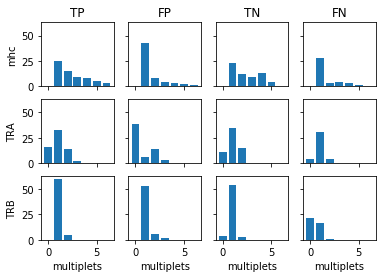

In [42]:
fig, axes = plt.subplots(3,4, sharex=True, sharey=True)
for axs, col in zip(axes, ['umi_count_lst_mhc', 'umi_count_lst_TRA', 'umi_count_lst_TRB']):
    for ax, (title, V) in zip(axs, [('TP', TP), ('FP', FP), ('TN', (ne & ~cl)), ('FN', (ne & cl))]):
        print(ax, title, col)
        df = m_df[V]
        data = df.apply(lambda row: len(row[col]), axis=1).value_counts()
        ax.bar(data.index, data.values)
        
        if ax.is_first_row():
            ax.set_title(title) 
        if ax.is_first_col():
            ax.set_ylabel(col[-3:])
        if ax.is_last_row():
            ax.set_xlabel('multiplets')
plt.show()

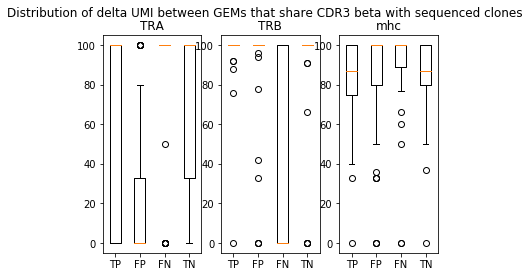

In [24]:
fig, axes = plt.subplots(1,3)

for ax, col in zip(axes, ['d_umi_TRA', 'd_umi_TRB', 'd_umi_mhc']):
    
    a = m_df[TP][col]
    b = m_df[FP][col]
    c = m_df[ne & cl][col]
    d = m_df[ne & ~cl][col]
    ax.boxplot([a,b,c,d])
    ax.set_title(col[-3:])
    ax.set_xticklabels(['TP', 'FP','FN', 'TN'])
    
fig.suptitle('Distribution of delta UMI between GEMs that share CDR3 beta with sequenced clones')
plt.show()

In [83]:
m_df

,clonotype,umi_count_lst_mhc,cdr3_TRA,cdr3_lst_TRA,umi_count_lst_TRA,cdr3_TRB,cdr3_lst_TRB,umi_count_lst_TRB,epitope,epitope_lst,...,v_resolved,d_resolved,j_resolved,d_umi_TRA,d_umi_TRB,d_umi_mhc,KLL_cdr3,HA-1_cdr3,HA-2_cdr3,ADIR_cdr3
0,clonotype17,"[1, 1, 8]",CVVNMYDFGNEKLTF,[CVVNMYDFGNEKLTF],[2],CSARTIGGPEAFF,[CSARTIGGPEAFF],[3],v15,"[HA-2, v14, v15]",...,NaN,NaN,NaN,8.0,12.0,6.0,False,False,False,False
1,None,"[1, 2, 4]",CAVRAPMDSSYKLIF,[CAVRAPMDSSYKLIF],[1],NaN,[],[],ADIR,"[KLL, v14, ADIR]",...,NaN,NaN,NaN,4.0,0.0,1.0,False,False,False,False
2,clonotype5,"[1, 3]",CSNSGSRLTF,[CSNSGSRLTF],[11],CASSQGTAEKLFF,"[CASSLVVVDEQFF, CASSQGTAEKLFF]","[3, 27]",ADIR,"[KLL, ADIR]",...,TCRBV04-01*01,unknown,TCRBJ01-04*01,44.0,8.0,2.0,False,True,False,True
3,None,[1],CALTGGGNKLTF,[CALTGGGNKLTF],[1],NaN,[],[],KLL,[KLL],...,NaN,NaN,NaN,4.0,0.0,4.0,False,False,False,False
4,clonotype3,"[1, 1, 6]",CATVLRMDSSYKLIF,[CATVLRMDSSYKLIF],[2],CASSQIGEGHGDEQFF,[CASSQIGEGHGDEQFF],[3],v14,"[ADIR, HA-1, v14]",...,NaN,NaN,NaN,8.0,12.0,4.0,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,clonotype104,[1],NaN,[],[],CASSLGTEIYNEQFF,[CASSLGTEIYNEQFF],[9],v14,[v14],...,NaN,NaN,NaN,0.0,36.0,4.0,False,False,False,False
222,None,[1],NaN,[],[],CAIRKQDQNTGELFF,[CAIRKQDQNTGELFF],[1],v14,[v14],...,TCRBV10-03*01,TCRBD01-01*01,TCRBJ02-02*01,0.0,4.0,4.0,True,False,False,False
223,None,[1],NaN,[],[],CASSLVVVDEQFF,[CASSLVVVDEQFF],[2],ADIR,[ADIR],...,TCRBV07-09*01,unknown,TCRBJ02-01*01,0.0,8.0,4.0,False,True,False,False
224,None,"[1, 8]",NaN,[],[],CASSLVVVDEQFF,[CASSLVVVDEQFF],[3],HA-1,"[ADIR, HA-1]",...,TCRBV07-09*01,unknown,TCRBJ02-01*01,0.0,12.0,6.0,False,True,False,False


In [45]:
x = m_df.umi_count_lst_TRA.apply(len).values
y = m_df.umi_count_lst_TRB.apply(len).values
z = m_df.umi_count_lst_mhc.apply(len).values

In [46]:
dct = dict(zip(['ADIR','KLL','HA-1','HA-2'], ['#1b9e77','#d95f02','#7570b3','#e7298a']))

m_df['color'] = m_df.epitope.map(dct)
m_df.loc[m_df.color.isna(), 'color'] = 'grey'

In [47]:
dct = dict(zip(['ADIR_TCRB','KLL_TCRB','HA-1-1_TCRB','HA-2-1_TCRB'], ['#1b9e77','#d95f02','#7570b3','#e7298a']))

m_df['ecolor'] = m_df.sample_name.map(dct)
m_df.loc[m_df.ecolor.isna(), 'ecolor'] = 'grey'

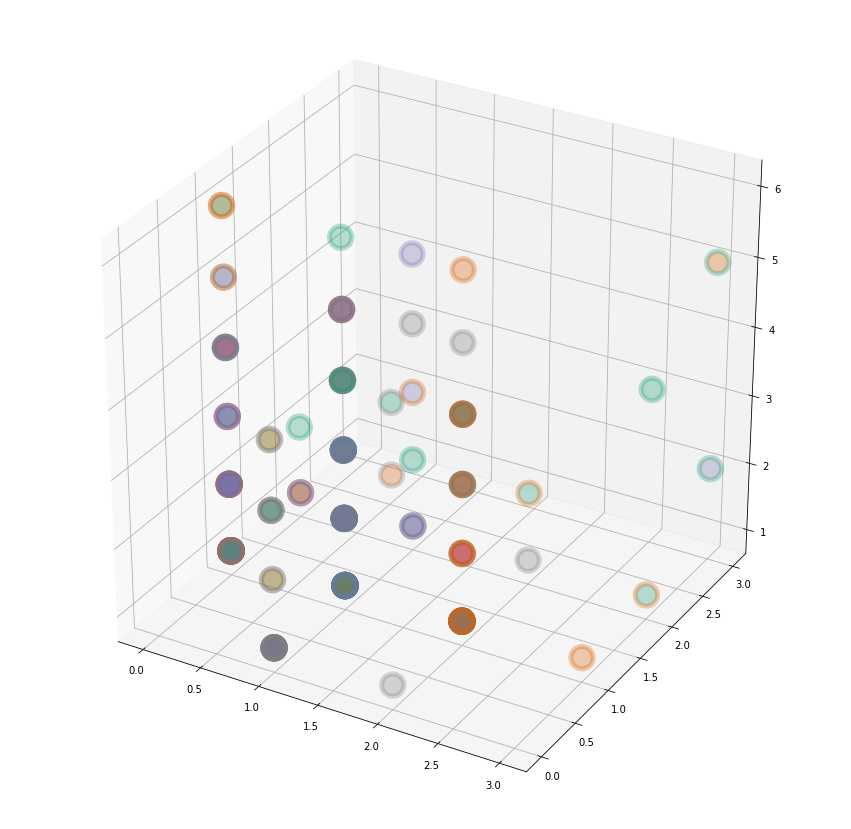

In [48]:
fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')
ax.scatter(x,y,z, alpha=0.3, fc=m_df.color, ec=m_df.ecolor, s=500,linewidth=5)

In [291]:
x

array([1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2,
       1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 2, 2, 2, 2, 1, 1,
       1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 3, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 3, 2, 1, 2, 3,
       1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2,
       1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [266]:
m_df.apply(lambda row: False if is_nan(row.sample_name) else (True if row.epitope in row.sample_name else False), axis=1)

0      False
1      False
2       True
3      False
4      False
       ...  
221    False
222    False
223    False
224     True
225     True
Length: 226, dtype: bool

In [276]:
m_df[m_df.epitope.isin(['ADIR','KLL','HA-1','HA-2']) & m_df.sample_name.isna()]

,clonotype,umi_count_lst_mhc,cdr3_TRA,umi_count_lst_TRA,cdr3_TRB,umi_count_lst_TRB,epitope,epitope_lst,peptide,sample_name,productive_frequency,templates,amino_acid,rearrangement,v_resolved,d_resolved,j_resolved,d_umi_TRA,d_umi_TRB,d_umi_mhc
1,None,"[1, 2, 4]",CAVRAPMDSSYKLIF,[1],NaN,[],ADIR,"[KLL, v14, ADIR]",SVAPALALFPA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,0,50
3,None,[1],CALTGGGNKLTF,[1],NaN,[],KLL,[KLL],KLLEIAPNC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,0,100
10,None,"[1, 2, 9]",CALTGGGNKLTF,[3],NaN,[],KLL,"[ADIR, v14, KLL]",KLLEIAPNC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,0,77
13,None,[1],CALTGGGNKLTF,[1],NaN,[],ADIR,[ADIR],SVAPALALFPA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,0,100
15,None,[1],CAETAGYGGSQGNLIF,[1],NaN,[],KLL,[KLL],KLLEIAPNC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,0,100
18,None,[1],CASPPGGAQKLVF,[4],NaN,[],HA-1,[HA-1],VLHDDLLEA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,0,100
19,None,[1],CAASNLVF,[1],NaN,[],ADIR,[ADIR],SVAPALALFPA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,0,100
22,None,[1],CAASNLVF,[1],NaN,[],HA-1,[HA-1],VLHDDLLEA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,0,100
23,None,[1],CAASNLVF,[1],NaN,[],HA-2,[HA-2],YIGEVLVSV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,0,100
29,clonotype16,[1],CATVASKLTF,[2],CASTPTGLGVDEQFF,[22],HA-2,[HA-2],YIGEVLVSV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,100,100


In [242]:
m_df.sample_name.isna()

0       True
1       True
2      False
3       True
4       True
       ...  
221     True
222    False
223    False
224    False
225    False
Name: sample_name, Length: 226, dtype: bool

In [241]:
m_df.sort_values(by='productive_frequency')

,clonotype,umi_count_lst_mhc,cdr3_TRA,umi_count_lst_TRA,cdr3_TRB,umi_count_lst_TRB,epitope,epitope_lst,peptide,sample_name,productive_frequency,templates,amino_acid,rearrangement,v_resolved,d_resolved,j_resolved,d_umi_TRA,d_umi_TRB,d_umi_mhc
2,clonotype5,"[1, 3]",CSNSGSRLTF,[11],CASSQGTAEKLFF,"[3, 27]",ADIR,"[KLL, ADIR]",SVAPALALFPA,ADIR_TCRB,0.974163,62098.0,CASSQGTAEKLFF,CACCTACACGCCCTGCAGCCAGAAGACTCAGCCCTGTATCTCTGCG...,TCRBV04-01*01,unknown,TCRBJ01-04*01,100,88,66
68,clonotype12,"[1, 1, 1, 7, 11]",CSNSGSRLTF,"[3, 4, 4]",CASSQGTAEKLFF,"[1, 15, 26]",KLL,"[v14, ADIR, HA-2, HA-1, KLL]",KLLEIAPNC,ADIR_TCRB,0.974163,62098.0,CASSQGTAEKLFF,CACCTACACGCCCTGCAGCCAGAAGACTCAGCCCTGTATCTCTGCG...,TCRBV04-01*01,unknown,TCRBJ01-04*01,0,42,36
72,clonotype5,"[1, 1, 1, 1]",CSNSGSRLTF,[3],CASSQGTAEKLFF,[24],ADIR,"[ADIR, KLL, HA-2, HA-1]",SVAPALALFPA,ADIR_TCRB,0.974163,62098.0,CASSQGTAEKLFF,CACCTACACGCCCTGCAGCCAGAAGACTCAGCCCTGTATCTCTGCG...,TCRBV04-01*01,unknown,TCRBJ01-04*01,100,100,0
76,clonotype73,[3],CAASNLVF,[1],CASSQGTAEKLFF,[8],ADIR,[ADIR],SVAPALALFPA,ADIR_TCRB,0.974163,62098.0,CASSQGTAEKLFF,CACCTACACGCCCTGCAGCCAGAAGACTCAGCCCTGTATCTCTGCG...,TCRBV04-01*01,unknown,TCRBJ01-04*01,100,100,100
79,clonotype12,"[1, 1, 3, 16]",CSNSGSRLTF,"[2, 3, 4]",CASSQGTAEKLFF,"[6, 25]",ADIR,"[v14, v15, HA-1, ADIR]",SVAPALALFPA,ADIR_TCRB,0.974163,62098.0,CASSQGTAEKLFF,CACCTACACGCCCTGCAGCCAGAAGACTCAGCCCTGTATCTCTGCG...,TCRBV04-01*01,unknown,TCRBJ01-04*01,25,76,81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,None,"[1, 1, 2, 11]",NaN,[],CASSQIGEGHGDEQFF,[2],v14,"[ADIR, HA-1, KLL, v14]",TPRVTGGGAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,100,81
212,None,[8],NaN,[],CASSQIGEGHGDEQFF,[1],HA-1,[HA-1],VLHDDLLEA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,100,100
215,None,[1],NaN,[],CASSSHDWGGQGSPLHF,[1],ADIR,[ADIR],SVAPALALFPA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,100,100
219,None,[1],NaN,[],CASLTGGRELFF,[1],HA-2,[HA-2],YIGEVLVSV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,100,100
